In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from io_utils import load_data_from_file
from main_methods import select_spatial_genes
from sim_utils import evaluate_rejections
from general_utils import norm_mtx
sns.set(style="whitegrid")


def load_results(method, sim_dir):
    sim_fn = os.path.join(sim_dir, 'sim_setup.csv')
    sim_df = load_data_from_file(sim_fn, 'csv')
    meth_dir = 'result_{}'.format(method)
    meth_dir = os.path.join(sim_dir, meth_dir)
    eval_fn = 'eval_{}.csv'.format(method)
    eval_fn = os.path.join(sim_dir, eval_fn)
    eval_df = load_data_from_file(eval_fn, 'csv')
    eval_df['method'] = method
    return eval_df

def load_simulation(sim_dir):
    method = 'ours'
    df_list = []
    for method in ['ours', 'spatialde', 'scgco']:
        sdf = load_results(method, sim_dir)
        df_list.append(sdf)
    df = pd.concat(df_list)
    display(df.shape)
    display(df.head())
    return df

def plot_comp(df, metric, ymax=None,  height=2.0, fn=None, legend=True):
    fig, ax = plt.subplots(1, 1, figsize=(5.5, height))
    my_pal = {"ours": '#ffb3b3', 
              "spatialde": '#b3ecff', 
              "scgco":'#d8ffcc'}
#     ax = sns.boxplot(x='temp', y=metric, hue='method', 
#                      data=df, palette=my_pal, ax=ax,
#                      boxprops=dict(alpha=1))
    ax = sns.barplot(x="temp", y=metric, hue="method", data=df,
                     palette=my_pal,  ax=ax, 
                     errwidth=1, errcolor='k',
                     linewidth=1, edgecolor='k')
    if ymax:
        ax.set_ylim(0, ymax)
    ax.set_xlabel(None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                  ncol=3,frameon=False)
    else:
        ax.legend().remove()
        ax.set_xticks([], [])

    plt.setp(ax.artists, alpha=1, linewidth=1)
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()

In [5]:
sim_dir = '/share/PI/sabatti/feat_viz/space_comp_sim/20191104'
fdir = '/scratch/PI/sabatti/spatial_subplots/'

(240, 9)

,FDP,Power,Power-Reg0,Power-Reg1,Power-Reg2,Power-Reg3,seed,temp,method
0,0.037500,0.77,1.0,1.0,1.0,0.08,0.0,linear,ours
1,0.012346,0.80,1.0,1.0,1.0,0.20,0.0,diaquad,ours
2,0.048780,0.78,1.0,1.0,1.0,0.12,0.0,radial,ours
3,0.050633,0.75,1.0,1.0,1.0,0.00,0.0,cosine,ours
4,0.012987,0.76,1.0,1.0,1.0,0.04,1.0,linear,ours


['FDP', 'Power', 'Power-Reg0', 'Power-Reg1', 'Power-Reg2', 'Power-Reg3']


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Saved figure to: /scratch/PI/sabatti/spatial_subplots/spatial_sim_fdp.pdf


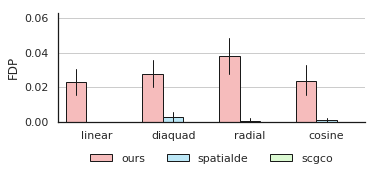

Saved figure to: /scratch/PI/sabatti/spatial_subplots/spatial_sim_power.pdf


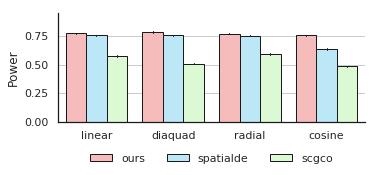

Saved figure to: /scratch/PI/sabatti/spatial_subplots/spatial_sim_Power-Reg0.pdf


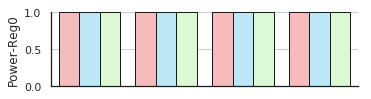

Saved figure to: /scratch/PI/sabatti/spatial_subplots/spatial_sim_Power-Reg1.pdf


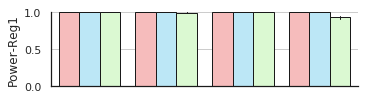

Saved figure to: /scratch/PI/sabatti/spatial_subplots/spatial_sim_Power-Reg2.pdf


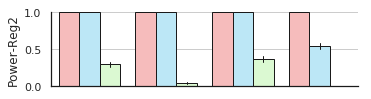

Saved figure to: /scratch/PI/sabatti/spatial_subplots/spatial_sim_Power-Reg3.pdf


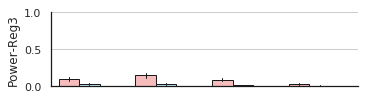

In [6]:
df1 = load_simulation(sim_dir)
pcols = df1.columns
pcols = pcols[pcols.str.startswith('Power')]
cols = ['FDP'] + list(pcols)
print(cols)
for col in cols:
    legend=True
    if col == 'Power':
        fn = fdir + 'spatial_sim_power.pdf'
        ymax = 0.95
        height=2.0
    elif col == 'FDP':
        fn = fdir + 'spatial_sim_fdp.pdf'
        ymax = 0.063
        height=2.0
    else:
        fn = fdir + 'spatial_sim_{}.pdf'.format(col)
        ymax = 1
        height = 1.35
        legend=False
    plot_comp(df1, col, ymax, height=height, fn=fn, legend=legend)

# Plot the coordinates from the simulation setup

raw data dim: (1056, 140)


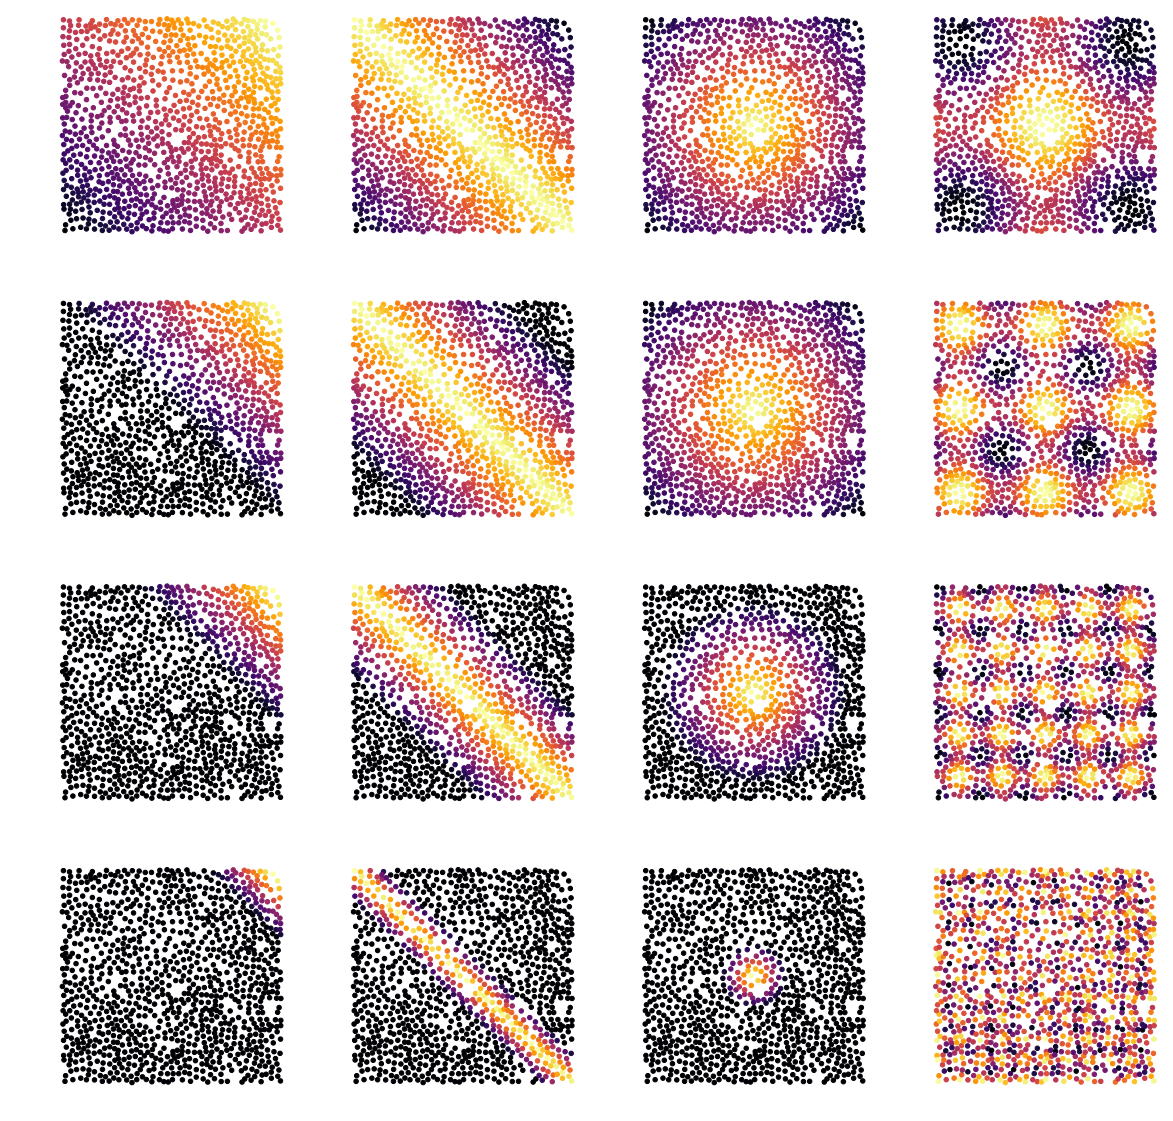

In [7]:
# load the data for a given replicate
from sim_utils import add_gaussian_noise, add_uniform_noise
from general_utils import read_spatial_expression, normalize_count_cellranger
from sim_utils import gen_2D_pattern, multi_2D_pattern
# from plot_utils import plot_scatter_continuous
from matplotlib.ticker import FormatStrFormatter

def plot_signals(embed_df, plt_df):
    n_plts = plt_df.shape[1]
    fig, axes = plt.subplots(n_plts, 1, figsize=(5.5, n_plts*5))
    for i, col in enumerate(plt_df.columns):
        ax = axes[i]
        scat = ax.scatter(embed_df['x'], embed_df['y'], c=plt_df[col], 
                alpha=1.0, s=20, cmap="inferno")
        ax.grid(False)
        ax.axis('off')
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.yaxis.set_ticks_position('left')
#         ax.xaxis.set_ticks_position('bottom')
#         plt.colorbar(scat, ax=ax, format=FormatStrFormatter('%.1f'))
#         plot_scatter_continuous(embed_df, plt_df[col], ax, logscale=False)
    plt.tight_layout()
    plt.show()
   
ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
ff = ddir + '/data/Raw_data/MERFISH/middle_scGCO_data_matrix.csv'
locs,data=read_spatial_expression(ff,sep=' ')
data_norm = normalize_count_cellranger(data)

# center the locations to zero and 1
loc_df = pd.DataFrame(locs, columns=['x', 'y'])
def center_unit(x):
    shift = (max(x) + min(x)) / 2
    scale = (max(x) - min(x)) / 2
    return (x - shift) / scale
loc_df['x'] = center_unit(loc_df['x'])
loc_df['y'] = center_unit(loc_df['y'])

# plot noiseless templates
temps = ['linear', 'diaquad', 'radial', 'cosine']
n = len(temps)
m = 4
fig, axes = plt.subplots(m, n, figsize=(n*5, m*5))
for j, t in enumerate(temps):
    tdf = multi_2D_pattern(t, loc_df['x'], loc_df['y'], n_regimes=m)
    tdf = pd.DataFrame(tdf)
    plt_df = tdf
    embed_df = loc_df
    for i, col in enumerate(plt_df.columns):
        ax = axes[i, j]
        scat = ax.scatter(embed_df['x'], embed_df['y'], c=plt_df[col], 
                alpha=1.0, s=20, cmap="inferno")
        ax.grid(False)
        ax.axis('off')
#         break